In [1]:
%load_ext autoreload
%autoreload 2
import json
import dgl
from sklearn.metrics import f1_score
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.dataloading import GraphDataLoader
import torch.nn.functional as F
import networkx as nx
import warnings
from feature_extraction.base_featurizer import BaseFeaturizer
import torch
from graph_construction.tps_graph import create_dummy_dgl_graph, tps_graph
import numpy as np

from dgl_classifier.trainer import GraphDataset,snap_pred, tps_to_dgl, get_clasification_vec,\
tps_graph_const, extract_data, runner


import warnings

from preprocessing.utils import load_BGPS_from_json
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [2]:
import json
path_to_res = '/work/data/results/8_6_2023_tp_graph_5re.txt'
path_to_res = '/work/data/results/8_6_2023_tp_graph_5re.txt'
results = json.load(open(path_to_res))

In [3]:
save_figs = '/work/files/'

In [4]:
import torch
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.RelGraphConv(in_dim, hidden_dim, 8)
        #self.conv1 = dglnn.GraphConv(in_dim, hidden_ˇdim)
        self.conv2 = dglnn.RelGraphConv(hidden_dim, hidden_dim, 8)
        #self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h, rel_types):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h, rel_types))
        h = F.relu(self.conv2(g, h, rel_types))
        with g.local_scope():
            g.ndata['node_features'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'node_features')
            return F.softmax( self.classify(hg), dim=1)
            #return F.sigmoid( self.classify(hg))
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.dropout = torch.nn.Dropout(.2)
        self.conv1 = dglnn.RelGraphConv(in_dim, hidden_dim, 8)
        #self.conv1 = dglnn.GraphConv(in_dim, hidden_ˇdim)
        self.conv2 = dglnn.RelGraphConv(hidden_dim, hidden_dim, 8)
        #self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h, rel_types):
        # Apply graph convolution and activation.
        h = self.dropout(h)
        h = F.relu(self.conv1(g, h, rel_types))
        h = self.dropout(h)
        h = F.relu(self.conv2(g, h, rel_types))
        h = self.dropout(h)
        with g.local_scope():
            g.ndata['node_features'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'node_features')
            return F.softmax( self.classify(hg), dim=1)
#model = Classifier(113, 20, 1)
best_model_path = '/work/data/models8_6/best_f1_model_178.pt'
#best_model_path = '/work/data/models8_6/model_107.pt'
model = torch.load(best_model_path)
model.eval()
model

Classifier(
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): RelGraphConv(
    (linear_r): TypedLinear(in_size=113, out_size=64, num_types=8)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (conv2): RelGraphConv(
    (linear_r): TypedLinear(in_size=64, out_size=64, num_types=8)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (classify): Linear(in_features=64, out_features=2, bias=True)
)

In [5]:
from dgl_classifier. trainer import predict2samples
train_file = '/work/data/splits/splits_0.050/train.json'
val_file = '/work/data/splits/splits_0.050/val.json'
test_file = '/work/data/splits/splits_0.050/test.json'
train_data, val_data,test_data = predict2samples(model,train_file, val_file, test_file, community_no=10, verbose=True, clust_verbose=False, clust_load_path='/work/data/confs/May2/pred_clust.json')

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return th.as_tensor(data, dtype=dtype)


In [6]:
from dgl_classifier.post import *
JB_train_rt, oracle_rt_train = get_runtime(train_data)
J_train_rt, B_train_rt = get_runtimes_wo_pred(train_data)

JB_val_rt, oracle_rt_val = get_runtime(val_data)
J_val_rt, B_val_rt = get_runtimes_wo_pred(val_data)

JB_test_rt, oracle_rt_test = get_runtime(test_data)
J_test_rt, B_test_rt = get_runtimes_wo_pred(test_data)

Here, we investigate what the average runtime with JenaBloom (Prediction), Jena, BF and Oracle (perfect classifier). The metric is in S, here.

In [7]:
print('Train\n','\tWith Predictions ',round(np.mean(JB_train_rt),3),', Jena: ', round(np.mean(J_train_rt),3), ', Bloom Filter',round(np.mean(B_train_rt),3),', Oracle',round(np.mean(oracle_rt_train),3))
print('Validation\n','\tWith Predictions ',round(np.mean(JB_val_rt),3),', Jena: ', round(np.mean(J_val_rt),3), ', Bloom Filter',round(np.mean(B_val_rt),3), ', Oracle',round(np.mean(oracle_rt_val),3))
print('Test\n','\tWith Predictions ',round(np.mean(JB_test_rt),3),', Jena: ', round(np.mean(J_test_rt),3), ', Bloom Filter',round(np.mean(B_test_rt),3),', Oracle',round(np.mean(oracle_rt_test),3))

Train
 	With Predictions  7.421 , Jena:  7.434 , Bloom Filter 8.161 , Oracle 7.407
Validation
 	With Predictions  8.47 , Jena:  8.627 , Bloom Filter 9.019 , Oracle 8.466
Test
 	With Predictions  4.183 , Jena:  4.189 , Bloom Filter 4.637 , Oracle 4.179


Now, we look into the relative improvements that we make possible with our model.
So these a wrt. to the Jena runtimes, (Jena runtimes are the "true", runtimes)

In [8]:
def relative_improvements(JB_rt, J):
    return [(( j-jb)/j)*100 for jb, j in zip(JB_rt, J)] 
train_re_im = relative_improvements(JB_train_rt,J_train_rt)
val_re_im = relative_improvements(JB_val_rt,J_val_rt)
test_re_im = relative_improvements(JB_test_rt,J_test_rt)

In [9]:
o_train_re_im = relative_improvements(oracle_rt_train,J_train_rt)
o_val_re_im = relative_improvements(oracle_rt_val,J_val_rt)
o_test_re_im = relative_improvements(oracle_rt_val,J_test_rt)

In [10]:
def print_stat(re_s):
    print("Mean ", round(np.mean(re_s),3))
    print("STD ", round(np.std(re_s),3))
    print("Min ", round(np.min(re_s),3))
    print("25% ", round(np.quantile(re_s,q=0.25),3))
    print("50% ", round(np.quantile(re_s,q=0.5),3))
    print("75% ", round(np.quantile(re_s,q=0.75),3))
    print("Max ", round(np.max(re_s),3))

In [11]:
print_stat(train_re_im)

Mean  3.235
STD  9.187
Min  -34.161
25%  0.0
50%  0.0
75%  6.161
Max  74.439


In [12]:
print_stat(val_re_im)

Mean  3.049
STD  9.932
Min  -41.818
25%  0.0
50%  0.0
75%  6.377
Max  42.866


In [13]:
print_stat(test_re_im)

Mean  1.096
STD  8.638
Min  -46.525
25%  0.0
50%  0.0
75%  4.307
Max  23.677


The improvements in the upper Quantile of validation

In [14]:
#average in upper quantile:
temp = []
for idx,x in enumerate(val_re_im):
    if x > 6.36:
        temp.append(x)
print('Validation AVG (upper tier', round(np.mean(temp),3))
temp = []
for idx,x in enumerate(test_re_im):
    if x > 4.3:
        temp.append(x)
print('Test AVG (upper tier', round(np.mean(temp),3))

Validation AVG (upper tier 13.504
Test AVG (upper tier 9.418


In [15]:
for idx,x in enumerate(val_re_im):
    if x > 6:
        print('Relative Improvement ',round(x,3),' JenaBloom RT ', round(JB_val_rt[idx],3),' Jena RT ', round(J_val_rt[idx],3), 'Absolute difference in MS',round((J_val_rt[idx] -JB_val_rt[idx] )*1e3,3))

Relative Improvement  9.158  JenaBloom RT  0.022  Jena RT  0.024 Absolute difference in MS 2.184
Relative Improvement  17.005  JenaBloom RT  0.026  Jena RT  0.031 Absolute difference in MS 5.242
Relative Improvement  10.751  JenaBloom RT  0.192  Jena RT  0.215 Absolute difference in MS 23.152
Relative Improvement  6.208  JenaBloom RT  0.011  Jena RT  0.012 Absolute difference in MS 0.736
Relative Improvement  42.866  JenaBloom RT  0.028  Jena RT  0.048 Absolute difference in MS 20.636
Relative Improvement  22.282  JenaBloom RT  0.007  Jena RT  0.01 Absolute difference in MS 2.127
Relative Improvement  8.819  JenaBloom RT  0.038  Jena RT  0.042 Absolute difference in MS 3.686
Relative Improvement  6.967  JenaBloom RT  0.014  Jena RT  0.016 Absolute difference in MS 1.084
Relative Improvement  26.28  JenaBloom RT  0.024  Jena RT  0.033 Absolute difference in MS 8.58
Relative Improvement  7.232  JenaBloom RT  0.053  Jena RT  0.057 Absolute difference in MS 4.125
Relative Improvement  11.6

Same with Test instead.

In [16]:
for idx,x in enumerate(test_re_im):
    if x > 4:
        print('Relative Improvement ',round(x,3),' JenaBloom RT ', round(JB_test_rt[idx],3),' Jena RT ', round(J_test_rt[idx],3), 'Absolute difference in MS',round((J_test_rt[idx] -JB_test_rt[idx] )*1e3,3))

Relative Improvement  11.458  JenaBloom RT  0.005  Jena RT  0.005 Absolute difference in MS 0.617
Relative Improvement  13.352  JenaBloom RT  0.192  Jena RT  0.222 Absolute difference in MS 29.655
Relative Improvement  5.236  JenaBloom RT  0.174  Jena RT  0.183 Absolute difference in MS 9.588
Relative Improvement  6.555  JenaBloom RT  0.02  Jena RT  0.021 Absolute difference in MS 1.384
Relative Improvement  6.334  JenaBloom RT  0.037  Jena RT  0.039 Absolute difference in MS 2.476
Relative Improvement  13.542  JenaBloom RT  0.014  Jena RT  0.017 Absolute difference in MS 2.269
Relative Improvement  6.373  JenaBloom RT  0.027  Jena RT  0.029 Absolute difference in MS 1.832
Relative Improvement  7.784  JenaBloom RT  0.28  Jena RT  0.304 Absolute difference in MS 23.659
Relative Improvement  8.653  JenaBloom RT  0.005  Jena RT  0.005 Absolute difference in MS 0.473
Relative Improvement  14.795  JenaBloom RT  0.06  Jena RT  0.07 Absolute difference in MS 10.407
Relative Improvement  10.46

How many cases can we improve on our test dataset?

In [78]:
round((len([x for x in test_re_im if x > 0]) / len(test_re_im))*100,3)

31.395

In [77]:
round((len([x for x in train_re_im if x > 0]) / len(train_re_im))*100,3)

34.94

How many cases can we improve on our Validation dataset?

In [76]:
round((len([x for x in val_re_im if x > 0]) / len(val_re_im))*100,3)

38.095

For train, RT gain for train, jena runtime, BF runtime, and JenaBloom

In [19]:
round( np.mean(J_train_rt)- np.mean(JB_train_rt),3), ', Jena: ', round(np.mean(J_train_rt),3), ', Bloom Filter', round(np.mean(B_train_rt),3), ', Oracle', round(np.mean(oracle_rt_train),3),', JenaBloom', round(np.mean(JB_train_rt),3)

(0.014,
 ', Jena: ',
 7.434,
 ', Bloom Filter',
 8.161,
 ', Oracle',
 7.407,
 ', JenaBloom',
 7.421)

Improvement in terms of the runtime in MS.

In [20]:
def improvement(J, JB):
    J = [x*1e3 for x in J]
    JB = [x*1e3 for x in JB]
    sum_J = np.sum(J)
    sum_JB = np.sum(JB)
    print(round(((sum_J-sum_JB)),3))
    return ((sum_J-sum_JB))
improvement(J_train_rt, JB_train_rt)
improvement(J_val_rt, JB_val_rt)
improvement(J_test_rt, JB_test_rt)

3395.106
13169.743
485.186


485.1863370001083

The average RT improvement over Jena

In [21]:
def rt_improvement(J, JB):
    sum_J = np.sum(J)
    sum_JB = np.sum(JB)
    print(round( ((sum_J-sum_JB)/sum_J)*100,3))
    return ((sum_J-sum_JB)/sum_J)*100
rt_improvement(J_train_rt, JB_train_rt)
rt_improvement(J_val_rt, JB_val_rt)
rt_improvement(J_test_rt, JB_test_rt)

0.183
1.817
0.135


0.13468653640312844

Workload speedup

In [22]:
def speedup(J, JB):
    sum_J = np.sum(J)
    sum_JB = np.sum(JB)
    print(sum_J/sum_JB)
speedup(J_train_rt, JB_train_rt)
speedup(J_val_rt, JB_val_rt)
speedup(J_test_rt, JB_test_rt)

1.0018374312374008
1.018510177976745
1.0013486818569115


In [23]:
speedup(J_train_rt, oracle_rt_train)
speedup(J_val_rt, oracle_rt_val)
speedup(J_test_rt, oracle_rt_test)

1.0036463247311769
1.018975711138944
1.0024136072241754


This is a macro average, which means that outliers (few bad predictions) can dominate these numbers.
This is also what happens.

In [24]:
import matplotlib.pyplot as plt

def bxp_rel_impr(re, title, save=None):
    plt.clf()
    plt.figure(figsize=(3,6))
    plt.ylabel('Relative Improvement (%)')
    plt.title(title)
    plt.boxplot(re)
    if save != None:
        plt.savefig(f'{save_figs}{save}.png')
    plt.show()

We plot the Relative Improvements for validation and test dataset

<Figure size 640x480 with 0 Axes>

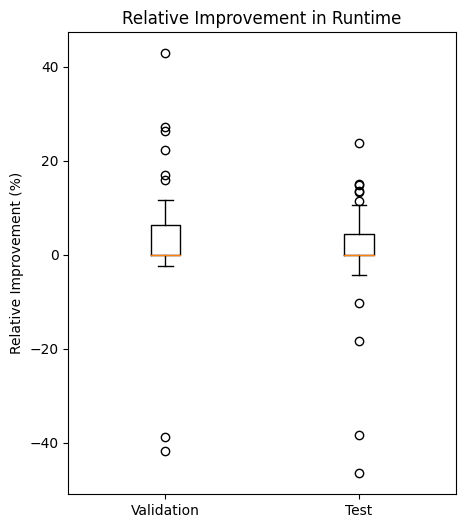

In [65]:
import pandas as pd

def bxp_rel_impr_w_both(re_val,re_test, title, save=None):
    for col_name,rel_impr  in zip(['Val Speedup','Test Speedup'], [re_val,re_test]):
        d = {col_name:rel_impr}
        df = pd.DataFrame(d)
        df.to_csv(f'{save_figs}{save}_{col_name}.csv', index = False)
    plt.clf()
    #plt.figure()
    fig, ax = plt.subplots(figsize=(5,6))
    data = {'Validation': re_val, 'Test': re_test}
    ax.boxplot(data.values())
    ax.set_xticklabels(data.keys())
    plt.ylabel('Relative Improvement (%)')
    plt.title(title)
    if save != None:
        plt.savefig(f'{save_figs}{save}.png', bbox_inches='tight')
    plt.show()
bxp_rel_impr_w_both(val_re_im,test_re_im, 'Relative Improvement in Runtime', save='rel_impro_rt')

So as observable, we have few bad classifications, 2 for validation and 5
These are the ones that dominate the macro average.

In [26]:
#print(val_re_im)
#print(test_re_im)

<Figure size 640x480 with 0 Axes>

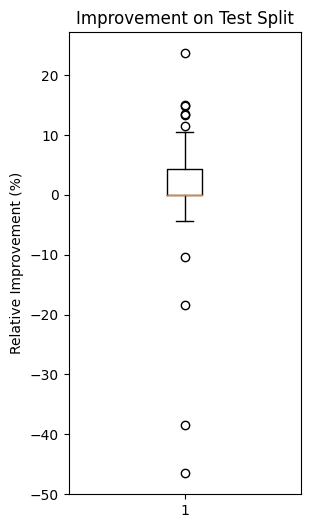

In [27]:
bxp_rel_impr(test_re_im, "Improvement on Test Split",save='test_re_impr_bxp')

In [28]:
#bxp_rel_impr(val_re_im, "Improvement on Val Split",save='val_re_impr_bxp')

In [29]:
for idx,x in enumerate(val_re_im):
    if x <0:
        print('Relative Decline ',round(x,3),' JenaBloom RT ', round(JB_val_rt[idx],3),' Jena RT ', round(J_val_rt[idx],3), 'Absolute difference in MS',round((J_val_rt[idx] -JB_val_rt[idx] )*1e3,3))

Relative Decline  -38.772  JenaBloom RT  0.086  Jena RT  0.062 Absolute difference in MS -23.976
Relative Decline  -41.818  JenaBloom RT  0.139  Jena RT  0.098 Absolute difference in MS -40.85
Relative Decline  -2.327  JenaBloom RT  0.034  Jena RT  0.033 Absolute difference in MS -0.775


In [30]:
for idx,x in enumerate(test_re_im):
    if x <0:
        print('Relative Decline ',round(x,3),' JenaBloom RT ', round(JB_test_rt[idx],3),' Jena RT ', round(J_test_rt[idx],3), 'Absolute difference in MS',round((J_test_rt[idx] -JB_test_rt[idx] )*1e3,3))

Relative Decline  -10.372  JenaBloom RT  0.013  Jena RT  0.012 Absolute difference in MS -1.245
Relative Decline  -3.107  JenaBloom RT  0.035  Jena RT  0.034 Absolute difference in MS -1.062
Relative Decline  -18.426  JenaBloom RT  0.003  Jena RT  0.003 Absolute difference in MS -0.514
Relative Decline  -46.525  JenaBloom RT  0.067  Jena RT  0.046 Absolute difference in MS -21.386
Relative Decline  -4.277  JenaBloom RT  0.228  Jena RT  0.219 Absolute difference in MS -9.36
Relative Decline  -38.396  JenaBloom RT  0.085  Jena RT  0.061 Absolute difference in MS -23.533


# Runtime Statistics

In [31]:
def differences_in_MS(J_rt, JB_rt):
    return [(j-jb)*1e3 for j, jb in zip(J_rt, JB_rt)]
val_dif = differences_in_MS(J_val_rt, JB_val_rt)
test_dif = differences_in_MS(J_test_rt, JB_test_rt)
print(np.sum(val_dif), np.sum(test_dif))

13169.743378000014 485.18633700000055


In [32]:
import pandas as pd
pd.DataFrame(val_dif)

,0
0,0.000000
1,2.184073
2,0.000000
3,5.241712
4,23.151874
...,...
79,0.761667
80,20.135561
81,0.000000
82,0.000000


In [33]:
list(range(-50,100,10))

[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

0
(-45.0, -40.0]     1
(-25.0, -20.0]     1
(-5.0, -0.1]       1
(-0.1, 0.0]       49
(0.0, 5.0]        19
(5.0, 10.0]        5
(20.0, 25.0]       4
(25.0, 30.0]       1
(75.0, 80.0]       1
(80.0, 85.0]       1
Name: count, dtype: int64


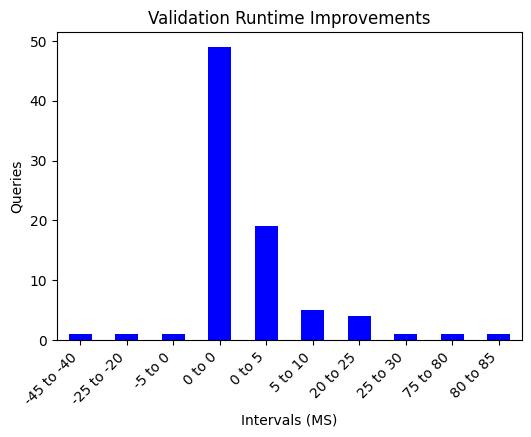

0
(-25.0, -20.0]     2
(-10.0, -5.0]      1
(-5.0, -0.1]       3
(-0.1, 0.0]       53
(0.0, 5.0]        18
(5.0, 10.0]        3
(10.0, 15.0]       2
(20.0, 25.0]       1
(25.0, 30.0]       1
(50.0, 55.0]       1
Name: count, dtype: int64


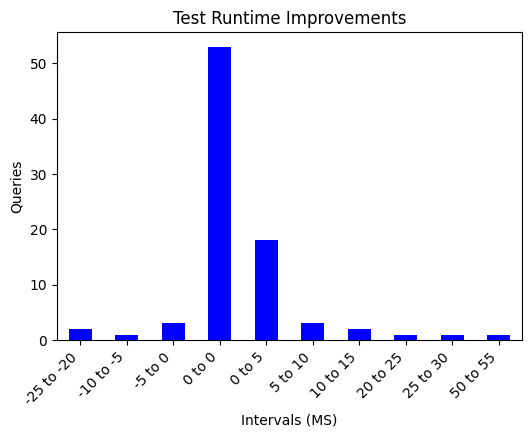

In [34]:
import pandas as pd
def difference_in_bar(diffs, title, save = None):
    s = pd.DataFrame(diffs)
    bins = list(range(-50,100,5))
    bins.append(-0.1)
    bins = sorted(bins)
    out = pd.cut(s[0], bins=bins, include_lowest=True)
    out = out.cat.remove_unused_categories()
    value_counts = out.value_counts(sort=False)
    print(value_counts)
    ys = [value_counts.iloc[x] for x in range(len(value_counts))]
    ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
    ax.set_xticklabels([f"{int(c.left)} to {int(c.right)}" for c in out.cat.categories],rotation = 45, ha="right")
    plt.title(title)
    plt.xlabel('Intervals (MS)')
    plt.ylabel('Queries')
    if save != None:
        plt.savefig(f'{save_figs}{save}.png', bbox_inches='tight')
    plt.show()
difference_in_bar(val_dif, 'Validation Runtime Improvements', save='no_improvements_val')
difference_in_bar(test_dif, 'Test Runtime Improvements', save='no_improvements_test')

# How good are our "positive" prediction?

In [35]:
list(train_data.values())[0].keys()

dict_keys(['bloom_runtime', 'jena_runtime', 'leapfrog', 'path', 'gt', 'bgp_construction_duration', 'tps_const_duration', 'prediction', 'inference_time'])

In [36]:
from dgl_classifier.post import get_BF_run_times

t_train_BF_runtimes, t_train_BF_oracle, t_train_BF_jena = get_BF_run_times(train_data)
t_val_BF_runtimes, t_val_BF_oracle, t_val_BF_jena = get_BF_run_times(val_data)
t_test_BF_runtimes, t_test_BF_oracle, t_test_BF_jena = get_BF_run_times(test_data)

In [37]:
print('Amount Predicted As Use BF')
print('Val: ', end = '')
print(len(t_val_BF_runtimes))
print('Test: ', end = '')
print(len(t_test_BF_runtimes))
print('Train: ', end = '')
print(len(t_train_BF_runtimes))

Amount Predicted As Use BF
Val: 47
Test: 38
Train: 106


In [61]:
print('Improvement in Validation')
print('JenaBloom: ')
print('Improvement in ms:', end= ' ')
improvement(t_val_BF_jena,t_val_BF_runtimes)
print('Relative Improvement (%):', end= ' ')
rt_improvement(t_val_BF_jena,t_val_BF_runtimes)
print('Oracle: ')
print('Improvement in ms:', end= ' ')
improvement(t_val_BF_jena,t_val_BF_oracle)
print('Relative Improvement (%):', end= ' ')
rt_improvement(t_val_BF_jena,t_val_BF_oracle)


print('Improvement in Test')
print('JenaBloom: ')
print('Improvement in ms:', end= ' ')
improvement(t_test_BF_jena,t_test_BF_runtimes)
print('Relative Improvement (%):', end= ' ')
rt_improvement(t_test_BF_jena,t_test_BF_runtimes)
print('Oracle: ')
print('Improvement in ms:', end= ' ')
improvement(t_val_BF_jena,t_val_BF_oracle)
print('Relative Improvement (%):', end= ' ')
rt_improvement(t_val_BF_jena,t_val_BF_oracle)

Improvement in Validation
JenaBloom: 
Improvement in ms: 591.454
Relative Improvement (%): 8.653
Oracle: 
Improvement in ms: 591.454
Relative Improvement (%): 8.653
Improvement in Test
JenaBloom: 
Improvement in ms: 467.715
Relative Improvement (%): 7.89
Oracle: 
Improvement in ms: 591.454
Relative Improvement (%): 8.653


8.652686621240262

In [39]:
#Improvement of oracle improvement


So we improve quite a bit on the queries where we use BF with our model.
The implication here is that our bad queries are only when we do not use BFs.


In [66]:
#results['test_prec'][np.argmin(results['val_loss'])]
import random
random.seed(21)
def make_random_bool_list(n):
  bool_list = []
  for i in range(n):
    bool_value = random.choice([True, False])
    bool_list.append(bool_value)
  return bool_list

def random_bool_list(data, runs = 20):
    runtimes = 0
    for x in data.keys():
        if not 'prediction' in data[x].keys():
            continue
        #if data[x]['gt']:
        runtimes+=1
    bool_lists = []
    for i in range(runs):
        bool_lists.append(make_random_bool_list(runtimes))
    return bool_lists
    
test_bools = random_bool_list(test_data)
print(test_bools)
val_bools = random_bool_list(val_data)
print(val_bools)

[[True, False, False, False, False, True, False, True, True, True, True, False, False, True, True, True, True, True, False, False, False, True, False, False, True, False, True, True, True, True, True, False, True, False, False, False, True, True, True, False, True, True, True, True, True, True, False, False, True, False, True, False, False, False, False, False, False, False, False, False, True, True, True, False, True, False, True, True, False, True, True, True, False, False, False, False, True, True, True, True, True, False, False, True, True, True], [False, True, True, False, False, False, True, True, True, True, False, False, False, True, False, True, False, False, True, False, True, True, False, True, False, True, True, False, True, False, True, False, True, True, False, True, False, False, False, False, False, True, False, True, True, False, True, True, False, False, True, False, False, False, True, True, True, True, False, True, True, True, False, True, True, True, False, True, F

In [67]:
def get_random_predictor_runtime(data, preds):
    runtimes = []
    idx = 0
    jena_rt_random = []
    for x in data.keys():
        if not 'prediction' in data[x].keys():
            continue
        jena_rt_random.append(data[x]['jena_runtime'])
        if preds[idx]:
            runtimes.append(data[x]['bloom_runtime'])
        else:
            runtimes.append(data[x]['jena_runtime'])
        idx += 1
    return runtimes, jena_rt_random
rel_improve = []
for x in test_bools:
    test_random_bf, jena_rt_random = get_random_predictor_runtime(test_data, x)
    rel_improve.append(rt_improvement(jena_rt_random,test_random_bf))
print('Mean Rel Improvement',np.mean(rel_improve))

-10.267
-10.668
-7.124
-7.787
-0.132
-7.589
-7.576
-9.734
-0.784
-0.114
-0.018
-10.403
-3.127
-7.706
-3.004
-7.65
-1.01
-10.416
-3.704
-7.542
Mean Rel Improvement -5.817740902589742


In [68]:
rel_improve = []
for x in val_bools:
    val_random_bf, jena_rt_random_val = get_random_predictor_runtime(val_data, x)
    rel_improve.append(rt_improvement(jena_rt_random_val,val_random_bf))
print('Mean Rel Improvement',np.mean(rel_improve))

-4.966
-5.339
-0.355
-0.604
-2.641
-1.588
-1.261
-1.336
-3.474
-3.423
-0.916
0.81
-4.196
0.211
-6.056
-1.427
-5.77
-1.85
-2.743
-4.777
Mean Rel Improvement -2.5851307634715113


In [42]:
print('Relative Improvement (%):', end= ' ')
t = rt_improvement(t_test_BF_jena,test_random_bf)
print(t)


Relative Improvement (%): -6435.064
-6435.063702861839


In [69]:
def get_always_true(data):
    runtimes = []
    jena_rt_random = []
    for x in data.keys():
        if not 'prediction' in data[x].keys():
            continue
        jena_rt_random.append(data[x]['jena_runtime'])
        runtimes.append(data[x]['bloom_runtime'])
    return runtimes, jena_rt_random
test_always_t_bf, jena_rt_test_always_t = get_always_true(test_data)
#1. Jena runtime 2. predictor runtime
impor = rt_improvement(jena_rt_test_always_t,test_always_t_bf)
val_always_t_bf, jena_rt_val_always_t = get_always_true(val_data)
#1. Jena runtime 2. predictor runtime
impor = rt_improvement(jena_rt_val_always_t,val_always_t_bf)

-10.695
-4.542


In [59]:
def effective_precision(jena_runtimes, prediction_runtimes):
    tps = 0.0
    fps = 0.0
    for jena, pred in zip(jena_runtimes, prediction_runtimes):
        if ((jena-pred)/jena) > 0:
            tps += 1
        else: 
            fps += 1
    return tps/(tps+fps)
#def single_rt_improvement(J, JB):
    
#    sum_J = np.sum(J)
#    sum_JB = np.sum(JB)
#    print(round( ((sum_J-sum_JB)/sum_J)*100,3))
#    return ((sum_J-sum_JB)/sum_J)*100
#t_test_BF_runtimes, t_test_BF_oracle, t_test_BF_jena
print('Validation')
print('JenaBloom: ')
print('Effective Precision:', end= ' ')
print(effective_precision(t_val_BF_jena, t_val_BF_runtimes))
#print(effective_precision(t_val_BF_jena, t_val_BF_runtimes))
print('Oracle: ')
print('Effective Precision):', end= ' ')
print(effective_precision(t_val_BF_jena,t_val_BF_oracle))

print('\n\n')
print('Test')
print('JenaBloom: ')
print('Effective Precision:', end= ' ')
print(effective_precision(t_test_BF_jena,t_test_BF_runtimes))
print('Oracle: ')
print('Effective Precision:', end= ' ')
print(effective_precision(t_test_BF_jena,t_test_BF_oracle))

Validation
JenaBloom: 
Effective Precision: 1.0
Oracle: 
Effective Precision): 1.0



Test
JenaBloom: 
Effective Precision: 1.0
Oracle: 
Effective Precision: 1.0
